# Approaching a Time Series Problem using Machine Learning

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

## Data: household power consumption

The dataset contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 
 
The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

1.date: Date in format dd/mm/yyyy 
 
2.time: time in format hh:mm:ss 
 
3.global_active_power: household global minute-averaged active power (in kilowatt) 
 
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
 
5.voltage: minute-averaged voltage (in volt) 
 
6.global_intensity: household global minute-averaged current intensity (in ampere) 
 
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
 
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
 
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



In [2]:
power = pd.read_csv("C:/Users/Thomas/Documents/BIDS/ML/household_power_consumption.txt.bz2",sep=";")
power.head()

C:\Users\Thomas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
power.dtypes 

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [4]:
power.Date = pd.to_datetime(power.Date,errors='coerce')
power.Time = pd.to_timedelta(power.Time)

In [5]:
power.Global_active_power = pd.to_numeric(power.Global_active_power,errors='coerce')
power.Global_intensity = pd.to_numeric(power.Global_intensity,errors='coerce')
power.Global_reactive_power = pd.to_numeric(power.Global_reactive_power,errors='coerce')
power.Sub_metering_1 = pd.to_numeric(power.Sub_metering_1,errors='coerce')
power.Sub_metering_2 = pd.to_numeric(power.Sub_metering_2,errors='coerce')
#power.Sub_metering_3 = pd.to_numeric(power.Sub_metering_3,errors='coerce')
power.Voltage = pd.to_numeric(power.Voltage,errors='coerce')

In [6]:
power.dtypes

Date                      datetime64[ns]
Time                     timedelta64[ns]
Global_active_power              float64
Global_reactive_power            float64
Voltage                          float64
Global_intensity                 float64
Sub_metering_1                   float64
Sub_metering_2                   float64
Sub_metering_3                   float64
dtype: object

In [7]:
power.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,0 days 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,0 days 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,0 days 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,0 days 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,0 days 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
power.describe()

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,0 days 11:59:32.744810015,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,0 days 06:55:41.677081176,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,0 days 00:00:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,0 days 06:00:00,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0 days 12:00:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,0 days 18:00:00,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,0 days 23:59:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


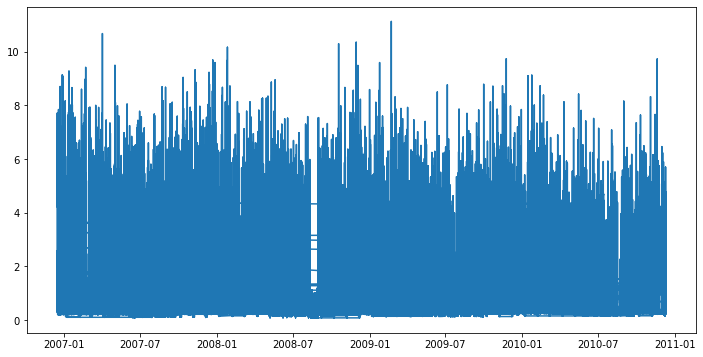

In [9]:
plt.figure(figsize=(12,6))
power.plt, = plt.plot(power.Date,power.Global_active_power)

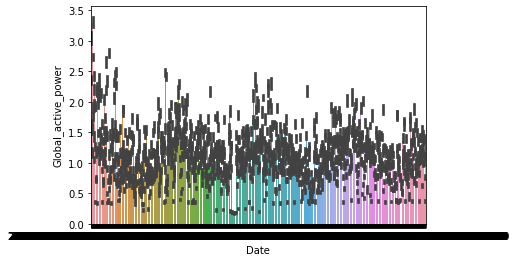

In [10]:
sns.barplot(power.Date,power.Global_active_power)

In [11]:
vacation = power.loc[(power.Date>'2008-08-01') & (power.Date<'2008-09-15')]
                     

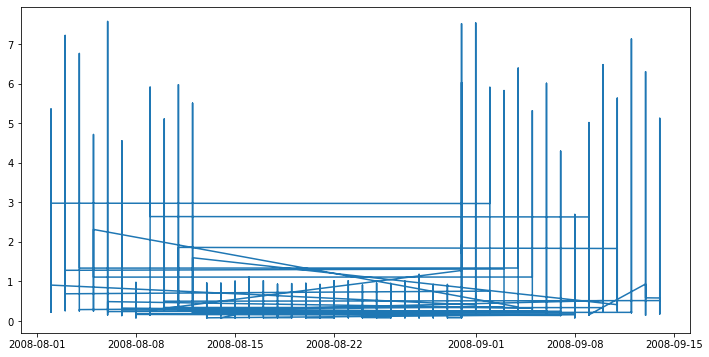

In [12]:
plt.figure(figsize=(12,6))
power.plt, = plt.plot(vacation.Date,vacation.Global_active_power)

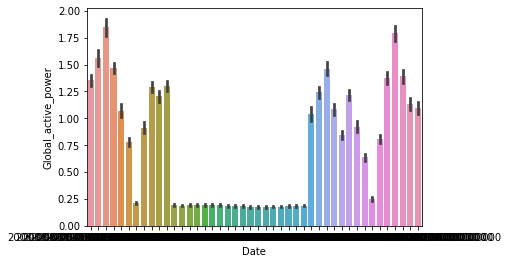

In [13]:
sns.barplot(vacation.Date,vacation.Global_active_power)

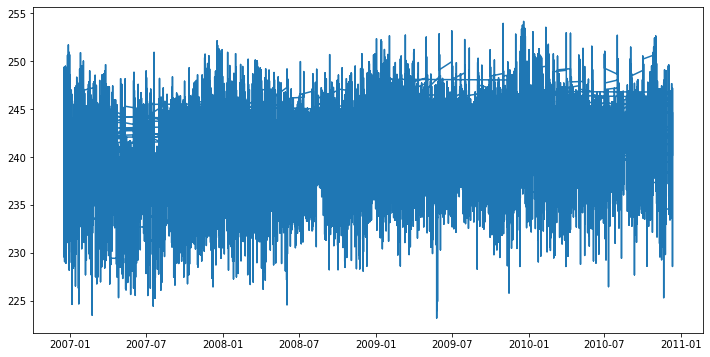

In [14]:
plt.figure(figsize=(12,6))
power.plt, = plt.plot(power.Date,power.Voltage)

In [53]:
from pyMechkar.analysis import train_test, Table1

In [16]:
X_train, X_test = train_test(power.dropna(), prop=0.7, seed=2)

Begining analysis...
Factorizing... please wait
*********
['The variable Date is a date. Dates are not allowed in Table1... avoided', "The variable Time doesn't exists in the dataset... avoiding"]
[**********
[**********
[]
------ Finished in 17.09703016281128econds -----
 
You got a perfectly balanced training and test datasets
 


In [17]:
print(X_train.shape)
print(X_test.shape)

(1434495, 10)
(614785, 10)


## Baseline models

outcome: Voltage

In [18]:
vn = ['Global_active_power','Global_reactive_power','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']

In [19]:
y_train = X_train['Voltage']
X_train = X_train[vn]
print(X_train.shape)
print(y_train.shape)

(1434495, 6)
(1434495,)


In [20]:
y_test = X_test['Voltage']
X_test = X_test[vn]
print(X_test.shape)
print(y_test.shape)

(614785, 6)
(614785,)


#### Linear Model

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression()
mod1 = lr.fit(X_train,y_train)
pred_tr = mod1.predict(X_train)

pred_ts = mod1.predict(X_test)

In [22]:
print('r^2 score: %f' % r2_score(y_train,pred_tr))
print('MAE: %f' % mean_absolute_error(y_train,pred_tr))

print('r^2 score: %f' % r2_score(y_test,pred_ts))
print('MAE: %f' % mean_absolute_error(y_test,pred_ts))

r^2 score: 0.248241
MAE: 2.123676
r^2 score: 0.247761
MAE: 2.124228


In [23]:
res = pd.DataFrame([{'model':'Linear Regression - Baseline',
                     'Train R^2':r2_score(y_train,pred_tr),'Train MAE':mean_absolute_error(y_train,pred_tr),
                     'Test R^2':r2_score(y_test,pred_ts),'Test MAE':mean_absolute_error(y_test,pred_ts)}])
res

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression - Baseline,0.248241,2.123676,0.247761,2.124228


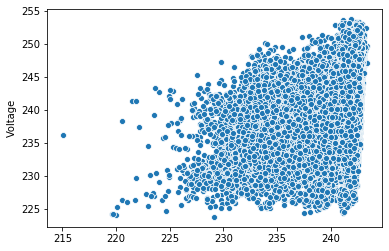

In [24]:
sns.scatterplot(pred_ts, y_test)

#### Decision Trees

In [25]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
lr = DecisionTreeRegressor()
mod2 = lr.fit(X_train,y_train)
pred2_tr = mod2.predict(X_train)

pred2_ts = mod2.predict(X_test)

In [27]:
res = res.append({'model':'Decision Tree',
                  'Train R^2':r2_score(y_train,pred2_tr),'Train MAE':mean_absolute_error(y_train,pred2_tr),
                  'Test R^2':r2_score(y_test,pred2_ts),'Test MAE':mean_absolute_error(y_test,pred2_ts)
                 },ignore_index=True)
                 
res

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression - Baseline,0.248241,2.123676,0.247761,2.124228
1,Decision Tree,0.745974,0.935871,0.393154,1.814220


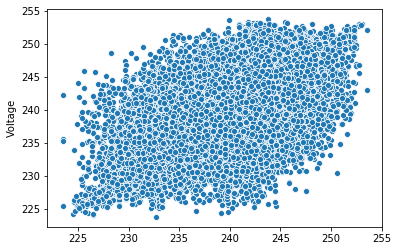

In [28]:
sns.scatterplot(pred2_ts, y_test)

#### Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
lr = RandomForestRegressor()
mod3 = lr.fit(X_train,y_train)
pred3_tr = mod3.predict(X_train)

pred3_ts = mod3.predict(X_test)

In [31]:
res = res.append({'model':'Random Forest',
                  'Train R^2':r2_score(y_train,pred3_tr),'Train MAE':mean_absolute_error(y_train,pred3_tr),
                  'Test R^2':r2_score(y_test,pred3_ts),'Test MAE':mean_absolute_error(y_test,pred3_ts)
                 },ignore_index=True)
res

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression - Baseline,0.248241,2.123676,0.247761,2.124228
1,Decision Tree,0.745974,0.935871,0.393154,1.814220
2,Random Forest,0.725051,1.139726,0.518989,1.634894


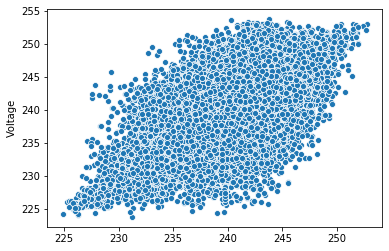

In [32]:
sns.scatterplot(pred3_ts, y_test)

#### AdaBoost

In [33]:
from sklearn.ensemble import AdaBoostRegressor

In [34]:
lr = AdaBoostRegressor()
mod4 = lr.fit(X_train,y_train)
pred4_tr = mod4.predict(X_train)

pred4_ts = mod4.predict(X_test)

In [35]:
res = res.append({'model':'AdaBoost',
                  'Train R^2':r2_score(y_train,pred4_tr),'Train MAE':mean_absolute_error(y_train,pred4_tr),
                  'Test R^2':r2_score(y_test,pred4_ts),'Test MAE':mean_absolute_error(y_test,pred4_ts)
                 },ignore_index=True)
res

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression - Baseline,0.248241,2.123676,0.247761,2.124228
1,Decision Tree,0.745974,0.935871,0.393154,1.814220
2,Random Forest,0.725051,1.139726,0.518989,1.634894
3,AdaBoost,0.250344,2.166626,0.249208,2.166017


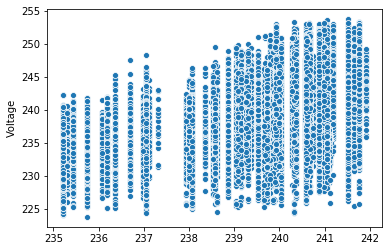

In [36]:
sns.scatterplot(pred4_ts, y_test)

#### Gradient Boosting

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

In [38]:
lr = GradientBoostingRegressor()
mod5 = lr.fit(X_train,y_train)
pred5_tr = mod5.predict(X_train)

pred5_ts = mod5.predict(X_test)

In [39]:
res = res.append({'model':'Gradient Boosting Machine',
                  'Train R^2':r2_score(y_train,pred5_tr),'Train MAE':mean_absolute_error(y_train,pred5_tr),
                  'Test R^2':r2_score(y_test,pred5_ts),'Test MAE':mean_absolute_error(y_test,pred5_ts)
                 },ignore_index=True)
res

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression - Baseline,0.248241,2.123676,0.247761,2.124228
1,Decision Tree,0.745974,0.935871,0.393154,1.814220
2,Random Forest,0.725051,1.139726,0.518989,1.634894
3,AdaBoost,0.250344,2.166626,0.249208,2.166017
4,Gradient Boosting Machine,0.380832,1.942226,0.378466,1.943867


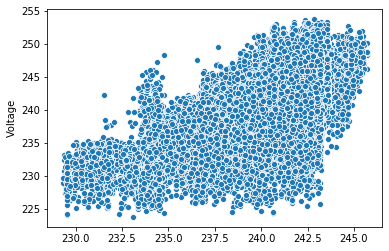

In [40]:
sns.scatterplot(pred5_ts, y_test)

#### SVM

In [173]:
#from sklearn.svm import SVR

lr = SVR()
mod6 = lr.fit(X_train,y_train)
pred6_tr = mod6.predict(X_train)

pred6_ts = mod6.predict(X_test)

res = res.append({'model':'SVM',
                  'Train R^2':r2_score(y_train,pred6_tr),'Train MAE':mean_absolute_error(y_train,pred6_tr),
                  'Test R^2':r2_score(y_test,pred6_ts),'Test MAE':mean_absolute_error(y_test,pred6_ts)
                 },ignore_index=True)
res

sns.scatterplot(pred6_ts, y_test)

#### Best Model

In [41]:
res

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression - Baseline,0.248241,2.123676,0.247761,2.124228
1,Decision Tree,0.745974,0.935871,0.393154,1.814220
2,Random Forest,0.725051,1.139726,0.518989,1.634894
3,AdaBoost,0.250344,2.166626,0.249208,2.166017
4,Gradient Boosting Machine,0.380832,1.942226,0.378466,1.943867


## How can we improve this model ?
 
HINT: analyzing the time series and using the knowledge we gain from this analysis to make feature engineering 

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox


In [10]:
vn2 = ['Voltage','Global_active_power','Global_reactive_power','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']

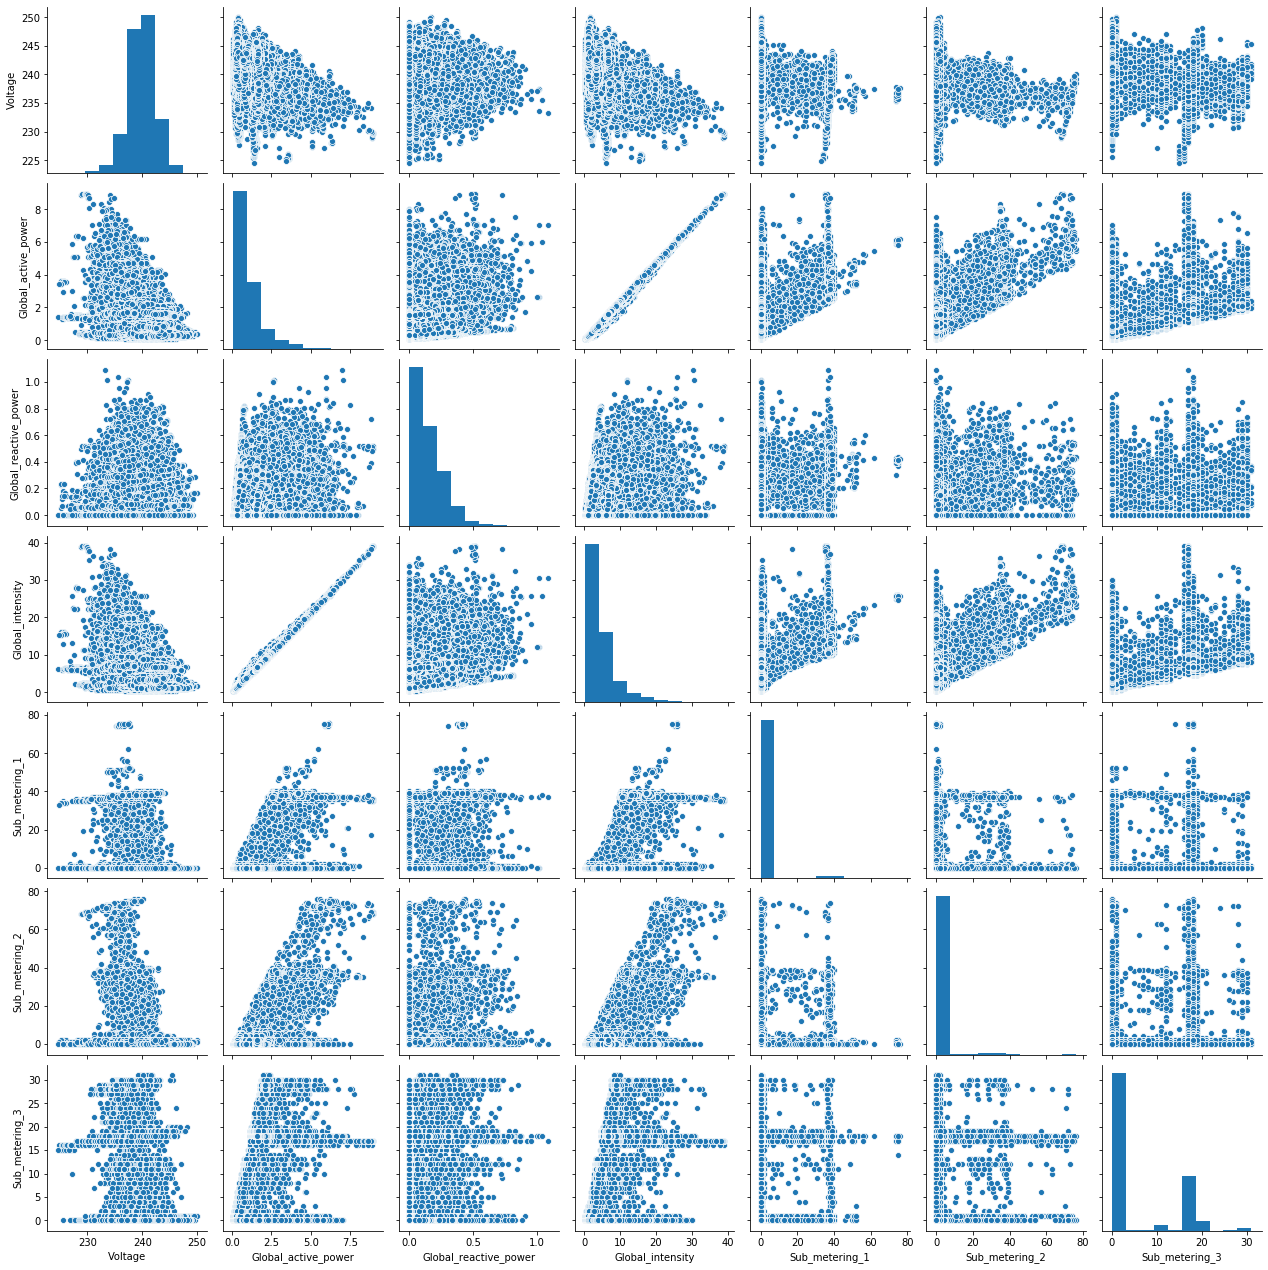

In [50]:
### plot a sample of data
sns.pairplot(power.loc[(power.Date>'2008-05-01') & (power.Date<'2008-07-31'),vn2])

Missing data in TS:
    
    Forward filling
    Backward filling
    Linear interpolation
    mean/median of nearest neighbours
    


In [11]:
power.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
### backward filling
power2 = power.fillna(method="bfill")
power2.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [248]:
### Forward filling
power2 = power.fillna(method="ffill")
power2.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Check for trends in the data

In [250]:
def plotTrend(data):
    ### check daily, weekly and monthly mean voltage
    fig, ax = plt.subplots(figsize = (11,4))

    ## ploting daily voltage
    daily = data.rolling(window=1440, center=True).mean()
    ax.plot(daily, marker='.', markersize=2, color='0.6', linestyle='None', label='Daily')

    ## ploting weekly voltage
    weekly = data.rolling(window=10080, center=True).mean()
    ax.plot(weekly, linewidth=2, label='Weekly')

    ## ploting monthly voltage
    montly = data.rolling(window=43200, center=True).mean()
    ax.plot(montly, linewidth=3, color='0.2', label='Trend (Monthly)')

    ### enhance the plot
    #ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_xlabel('Date')
    #ax.set_ylabel('Voltage')
    ax.set_title('Trends')

C:\Users\Thomas\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


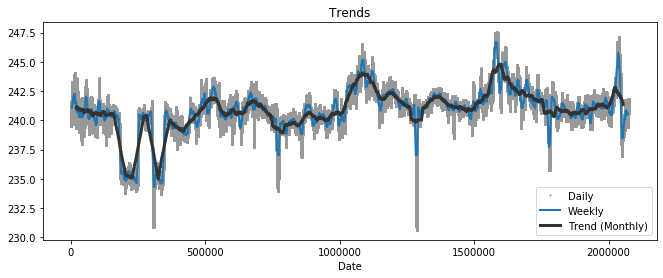

In [251]:
plotTrend(power2['Voltage'])

C:\Users\Thomas\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


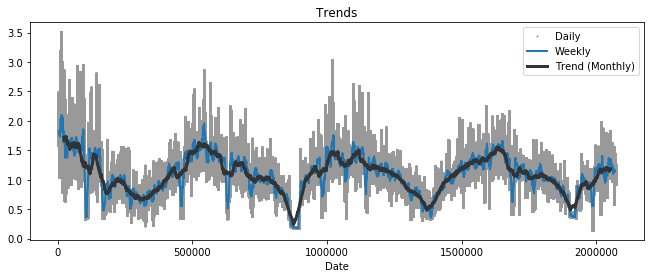

In [78]:
plotTrend(power2['Global_active_power'])

C:\Users\Thomas\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


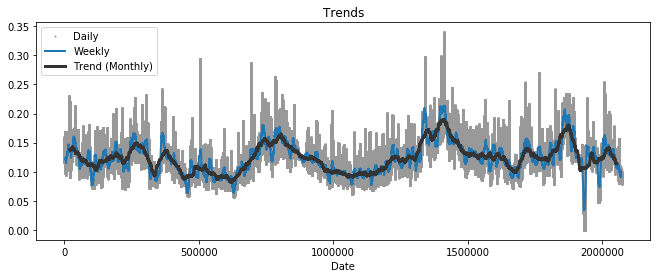

In [79]:
plotTrend(power2['Global_reactive_power'])

C:\Users\Thomas\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


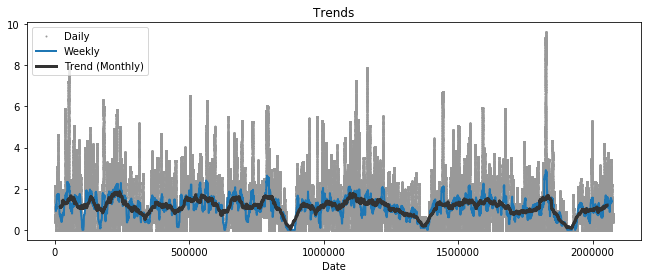

In [80]:
plotTrend(power2['Sub_metering_1'])

C:\Users\Thomas\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


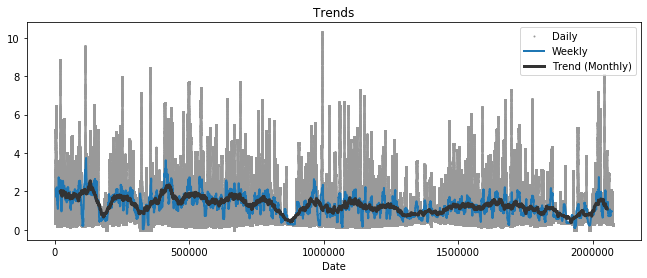

In [81]:
plotTrend(power2['Sub_metering_2'])

C:\Users\Thomas\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


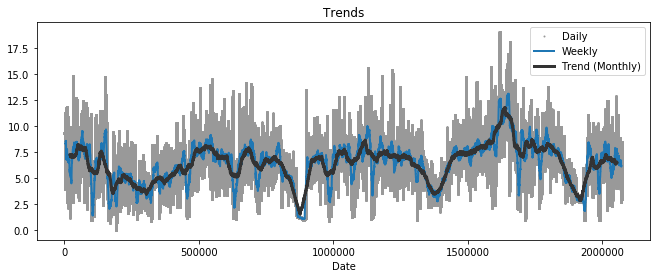

In [82]:
plotTrend(power2['Sub_metering_3'])

### TS Differenciation

In [14]:
### differentiate the whole vector
firstorder = power2[vn2].diff()

In [26]:
firstorder.head()

,Voltage,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.21,1.144,0.018,4.6,0.0,0.0,-1.0
2,-0.34,0.014,0.062,0.0,0.0,1.0,1.0
3,0.45,0.014,0.004,0.0,0.0,-1.0,0.0
4,1.94,-1.722,0.026,-7.2,0.0,0.0,0.0


In [15]:
start, end = '2008-01-01', '2009-01-01'

In [16]:
## check if the diff data for Voltage is stationary

dftest = adfuller(firstorder.loc[start:end,'Voltage'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("p.value = {:.3f}".format(dftest[1]))
print("Critical values = :")
for k,v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k,v,'not' if v< dftest[0] else '', 100-int(k[:-1])))


Test statistic = -11.924
p.value = 0.000
Critical values = :
	1%: -3.4369525024039884 - The data is  stationary with 99% confidence
	5%: -2.8644550095200705 - The data is  stationary with 95% confidence
	10%: -2.568322093455802 - The data is  stationary with 90% confidence


In [17]:
## check if the diff data has autocorrelation
stat, pval = acorr_ljungbox(firstorder.loc[start:end,'Voltage'],lags=1)
print('Ljung-Box autocorrelation - coef={}, p.val={}'.format(stat,pval))

Ljung-Box autocorrelation - coef=[9.45753307], p.val=[0.00210284]


C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


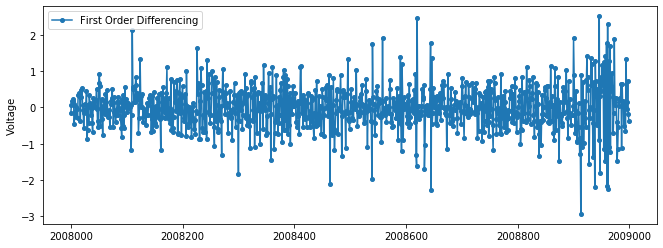

In [18]:
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(firstorder.loc[start:end, 'Voltage'], marker='o', markersize=4, linestyle='-',label='First Order Differencing')
ax.set_ylabel('Voltage')
ax.legend()

In [19]:
## seasonal differencing
seasondiff = firstorder.diff()

In [20]:
## check if the diff data is stationary
dftest = adfuller(seasondiff.loc[start:end,'Voltage'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("p.value = {:.3f}".format(dftest[1]))
print("Critical values = :")
for k,v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k,v,'not' if v< dftest[0] else '', 100-int(k[:-1])))


Test statistic = -11.702
p.value = 0.000
Critical values = :
	1%: -3.43706091543889 - The data is  stationary with 99% confidence
	5%: -2.8645028204932483 - The data is  stationary with 95% confidence
	10%: -2.568347558984588 - The data is  stationary with 90% confidence


In [21]:
## check if the diff data has autocorrelation
stat, pval = acorr_ljungbox(seasondiff.loc[start:end,'Voltage'],lags=1)
print('Ljung-Box autocorrelation - coef={}, p.val={}'.format(stat,pval))

Ljung-Box autocorrelation - coef=[298.92860514], p.val=[5.63888961e-67]


C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


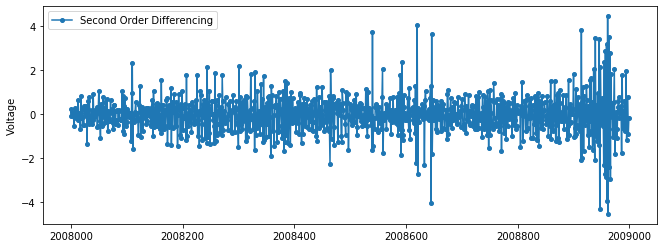

In [22]:
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(seasondiff.loc[start:end, 'Voltage'], marker='o', markersize=4, linestyle='-',label='Second Order Differencing')
ax.set_ylabel('Voltage')
ax.legend()

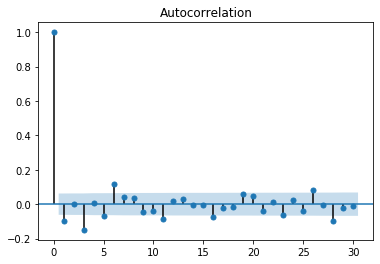

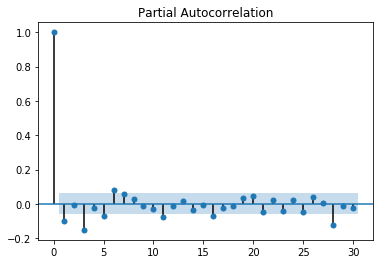

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(firstorder.loc[start:end,'Voltage'])
pacf = plot_pacf(firstorder.loc[start:end,'Voltage'])

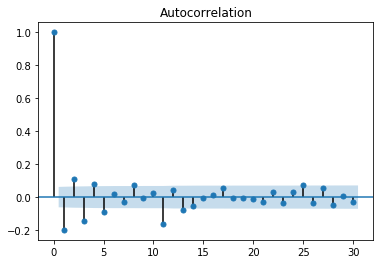

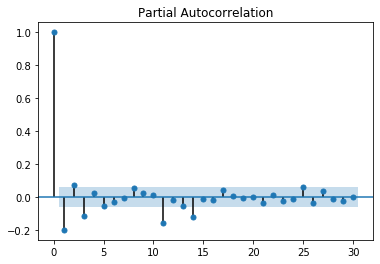

In [24]:
acf = plot_acf(firstorder.loc[start:end,'Global_active_power'])
pacf = plot_pacf(firstorder.loc[start:end,'Global_active_power'])

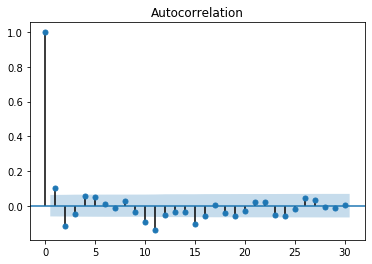

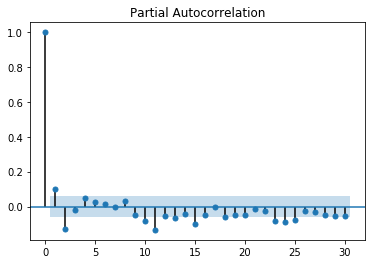

In [25]:
acf = plot_acf(firstorder.loc[start:end,'Global_reactive_power'])
pacf = plot_pacf(firstorder.loc[start:end,'Global_reactive_power'])

C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:578: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


LinAlgError: Singular matrix

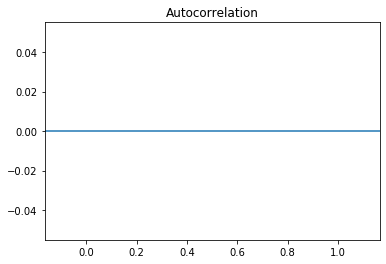

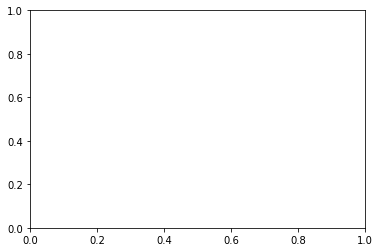

In [27]:
acf = plot_acf(firstorder.loc[start:end,'Sub_metering_1'])
pacf = plot_pacf(firstorder.loc[start:end,'Sub_metering_1'])

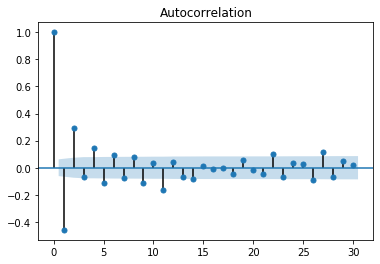

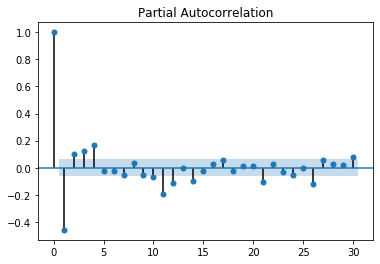

In [28]:
acf = plot_acf(firstorder.loc[start:end,'Sub_metering_2'])
pacf = plot_pacf(firstorder.loc[start:end,'Sub_metering_2'])

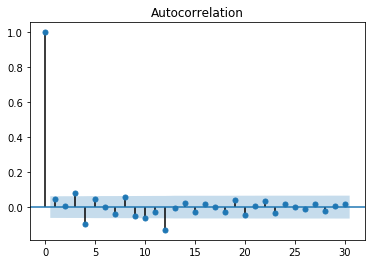

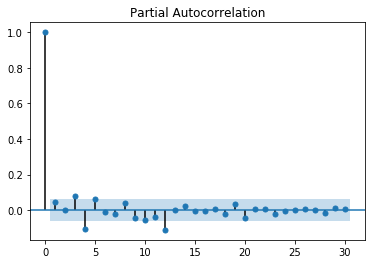

In [29]:
acf = plot_acf(firstorder.loc[start:end,'Sub_metering_3'])
pacf = plot_pacf(firstorder.loc[start:end,'Sub_metering_3'])

### TS Decomposition

In [66]:
#power2.set_index('Date',inplace=True)
power2 = power2.set_index(pd.to_datetime(power.Date+power.Time))

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


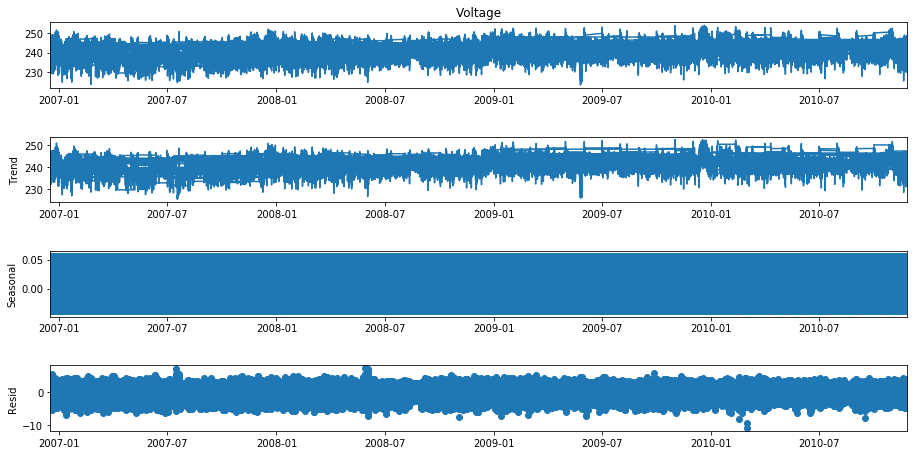

In [67]:
dec = seasonal_decompose(x=power2['Voltage'], model='additive', extrapolate_trend='freq',period=30)
fig = dec.plot()
fig.set_size_inches(14,7)
fig.show()

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


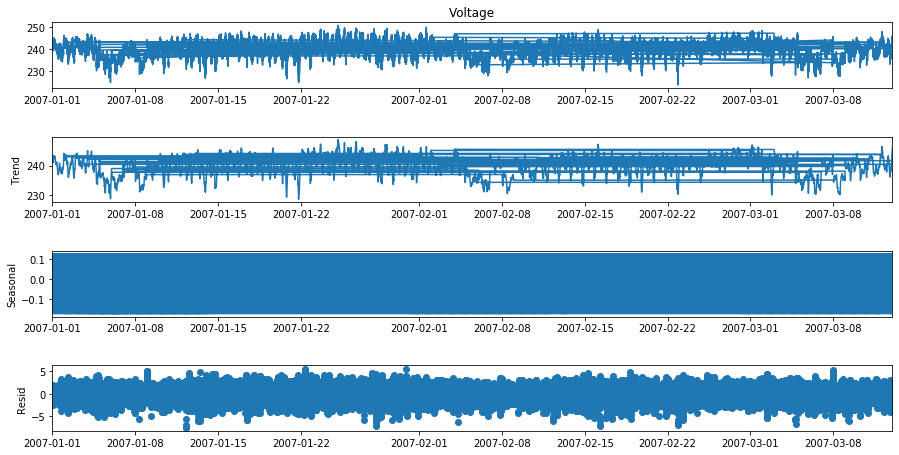

In [77]:
start, end = '2007-01-01','2007-03-31'
dec = seasonal_decompose(x=power2.loc[start:end,'Voltage'], model='additive', extrapolate_trend='freq',period=60)
fig = dec.plot()
fig.set_size_inches(14,7)
fig.show()

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


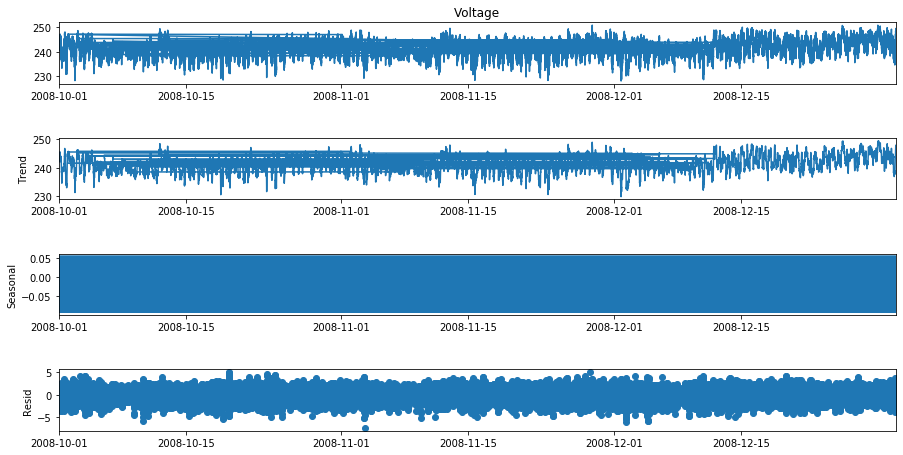

In [69]:
start, end = '2008-10-01','2008-12-31'
dec = seasonal_decompose(x=power2.loc[start:end,'Voltage'], model='additive', extrapolate_trend='freq',period=30)
fig = dec.plot()
fig.set_size_inches(14,7)
fig.show()

In [70]:
print(dec.seasonal[0:59],dec.seasonal[60:119])

2008-10-01 00:00:00   -0.064477
2008-10-01 00:01:00   -0.091424
2008-10-01 00:02:00   -0.077680
2008-10-01 00:03:00   -0.064717
2008-10-01 00:04:00   -0.039194
2008-10-01 00:05:00    0.014314
2008-10-01 00:06:00    0.012187
2008-10-01 00:07:00    0.016807
2008-10-01 00:08:00    0.020239
2008-10-01 00:09:00    0.009812
2008-10-01 00:10:00   -0.019436
2008-10-01 00:11:00   -0.030950
2008-10-01 00:12:00   -0.009808
2008-10-01 00:13:00   -0.003603
2008-10-01 00:14:00   -0.013131
2008-10-01 00:15:00    0.032001
2008-10-01 00:16:00    0.026994
2008-10-01 00:17:00    0.033305
2008-10-01 00:18:00    0.045546
2008-10-01 00:19:00    0.047588
2008-10-01 00:20:00    0.053130
2008-10-01 00:21:00    0.031379
2008-10-01 00:22:00    0.043118
2008-10-01 00:23:00    0.052201
2008-10-01 00:24:00    0.014760
2008-10-01 00:25:00    0.028442
2008-10-01 00:26:00    0.003415
2008-10-01 00:27:00   -0.011799
2008-10-01 00:28:00   -0.029558
2008-10-01 00:29:00   -0.029460
2008-10-01 00:30:00   -0.064477
2008-10-

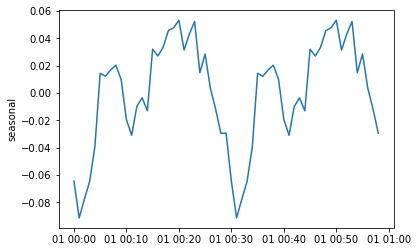

In [76]:
sns.lineplot(x=dec.seasonal[0:59].index,y=dec.seasonal[0:59])

In [236]:
dec = seasonal_decompose(x=power2['Voltage'], model='additive', extrapolate_trend='freq',period=60)

In [238]:
seasonality = dec.seasonal
len(seasonality)

2075259

### Run a Vector Autoregression Model (VAR)

In [92]:
cor_res = pd.DataFrame(columns=['var1','var2','lag','correlation','p_value'])
# correlation between voltage and lagged 
for lag in range(1,60):
    volt = power2['Voltage'].iloc[lag:]
    poweract = power2['Global_active_power'].iloc[lag:]
    pwrreact = power2['Global_reactive_power'].iloc[lag:]
    met2 = power2['Sub_metering_2'].iloc[lag:]
    met3 = power2['Sub_metering_3'].iloc[lag:]
 
    cor, p_value = pearsonr(volt,poweract)
    cor_res = cor_res.append({'var1':'Voltage','var2':'Global_active_power','lag':lag,'correlation':cor,'p_value':p_value},ignore_index=True)
    cor, p_value = pearsonr(volt,pwrreact)
    cor_res = cor_res.append({'var1':'Voltage','var2':'Global_reactive_power','lag':lag,'correlation':cor,'p_value':p_value},ignore_index=True)
    cor, p_value = pearsonr(volt,met2)
    cor_res = cor_res.append({'var1':'Voltage','var2':'Sub_metering_2','lag':lag,'correlation':cor,'p_value':p_value},ignore_index=True)
    cor, p_value = pearsonr(volt,met3)
    cor_res = cor_res.append({'var1':'Voltage','var2':'Sub_metering_3','lag':lag,'correlation':cor,'p_value':p_value},ignore_index=True)


In [123]:
cor_res = []
# correlation between voltage and lagged 
for lag in range(1,60):
    volt = power2['Voltage'].iloc[lag:]
    poweract = power2['Global_active_power'].iloc[:-lag]
    pwrreact = power2['Global_reactive_power'].iloc[:-lag]
    met2 = power2['Sub_metering_2'].iloc[:-lag]
    met3 = power2['Sub_metering_3'].iloc[:-lag]
 
    cor, p_value = pearsonr(volt,poweract)
    cor_res.append(['Voltage','Global_active_power',lag,cor,p_value])
    cor, p_value = pearsonr(volt,pwrreact)
    cor_res.append(['Voltage','Global_reactive_power',lag,cor,p_value])
    cor, p_value = pearsonr(volt,met2)
    cor_res.append(['Voltage','Sub_metering_2',lag,cor,p_value])
    cor, p_value = pearsonr(volt,met3)
    cor_res.append(['Voltage','Sub_metering_3',lag,cor,p_value])

cor_res = pd.DataFrame(cor_res, columns=['var1','var2','lag','correlation','p_value'])

In [124]:
cor_res

,var1,var2,lag,correlation,p_value
0,Voltage,Global_active_power,1,-0.384522,0.0
1,Voltage,Global_reactive_power,1,-0.108665,0.0
2,Voltage,Sub_metering_2,1,-0.157900,0.0
3,Voltage,Sub_metering_3,1,-0.257923,0.0
4,Voltage,Global_active_power,2,-0.372500,0.0
...,...,...,...,...,...
231,Voltage,Sub_metering_3,58,-0.133519,0.0
232,Voltage,Global_active_power,59,-0.176908,0.0
233,Voltage,Global_reactive_power,59,-0.061296,0.0
234,Voltage,Sub_metering_2,59,-0.051783,0.0


In [126]:
cor_res.loc[cor_res.p_value<0.05]

,var1,var2,lag,correlation,p_value
0,Voltage,Global_active_power,1,-0.384522,0.0
1,Voltage,Global_reactive_power,1,-0.108665,0.0
2,Voltage,Sub_metering_2,1,-0.157900,0.0
3,Voltage,Sub_metering_3,1,-0.257923,0.0
4,Voltage,Global_active_power,2,-0.372500,0.0
...,...,...,...,...,...
231,Voltage,Sub_metering_3,58,-0.133519,0.0
232,Voltage,Global_active_power,59,-0.176908,0.0
233,Voltage,Global_reactive_power,59,-0.061296,0.0
234,Voltage,Sub_metering_2,59,-0.051783,0.0


In [131]:
cor_res.loc[cor_res.p_value>=0.05]

,var1,var2,lag,correlation,p_value


In [127]:
cor_res.loc[cor_res.lag==1]

,var1,var2,lag,correlation,p_value
0,Voltage,Global_active_power,1,-0.384522,0.0
1,Voltage,Global_reactive_power,1,-0.108665,0.0
2,Voltage,Sub_metering_2,1,-0.157900,0.0
3,Voltage,Sub_metering_3,1,-0.257923,0.0


In [128]:
cor_res.loc[cor_res.lag==2]

,var1,var2,lag,correlation,p_value
4,Voltage,Global_active_power,2,-0.372500,0.0
5,Voltage,Global_reactive_power,2,-0.104419,0.0
6,Voltage,Sub_metering_2,2,-0.155127,0.0
7,Voltage,Sub_metering_3,2,-0.254345,0.0


In [130]:
cor_res.loc[cor_res.lag==3]

,var1,var2,lag,correlation,p_value
8,Voltage,Global_active_power,3,-0.362904,0.0
9,Voltage,Global_reactive_power,3,-0.100299,0.0
10,Voltage,Sub_metering_2,3,-0.150878,0.0
11,Voltage,Sub_metering_3,3,-0.250670,0.0


In [134]:
cor_res.loc[cor_res.lag==10]

,var1,var2,lag,correlation,p_value
36,Voltage,Global_active_power,10,-0.317581,0.0
37,Voltage,Global_reactive_power,10,-0.080462,0.0
38,Voltage,Sub_metering_2,10,-0.120738,0.0
39,Voltage,Sub_metering_3,10,-0.232060,0.0


#### Var fitting

In [136]:
varmod = VAR(power2[['Voltage','Global_active_power','Global_reactive_power','Sub_metering_2','Sub_metering_3']])

C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


In [137]:
varfit = varmod.fit(maxlags=60)

In [140]:
varfit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 31, Oct, 2020
Time:                     21:35:37
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -8.83982
Nobs:                 2.07520e+06    HQIC:                  -8.84649
Log likelihood:      -5.53976e+06    FPE:                0.000143537
AIC:                     -8.84892    Det(Omega_mle):     0.000143433
--------------------------------------------------------------------
Results for equation Voltage
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             1.695751         0.035506           47.760           0.000
L1.Voltage                        0.963052         0.000779         1236.361           0.000
L1.Global_

In [182]:
finalvar = varfit.summary()

In [197]:
pval = np.concatenate(finalvar.model.pvalues[0:60]).tolist()
len(pval)

300

In [198]:
len(finalvar.model.exog_names)

301

In [200]:
finalvar.model.exog_names[1:301]

['L1.Voltage',
 'L1.Global_active_power',
 'L1.Global_reactive_power',
 'L1.Sub_metering_2',
 'L1.Sub_metering_3',
 'L2.Voltage',
 'L2.Global_active_power',
 'L2.Global_reactive_power',
 'L2.Sub_metering_2',
 'L2.Sub_metering_3',
 'L3.Voltage',
 'L3.Global_active_power',
 'L3.Global_reactive_power',
 'L3.Sub_metering_2',
 'L3.Sub_metering_3',
 'L4.Voltage',
 'L4.Global_active_power',
 'L4.Global_reactive_power',
 'L4.Sub_metering_2',
 'L4.Sub_metering_3',
 'L5.Voltage',
 'L5.Global_active_power',
 'L5.Global_reactive_power',
 'L5.Sub_metering_2',
 'L5.Sub_metering_3',
 'L6.Voltage',
 'L6.Global_active_power',
 'L6.Global_reactive_power',
 'L6.Sub_metering_2',
 'L6.Sub_metering_3',
 'L7.Voltage',
 'L7.Global_active_power',
 'L7.Global_reactive_power',
 'L7.Sub_metering_2',
 'L7.Sub_metering_3',
 'L8.Voltage',
 'L8.Global_active_power',
 'L8.Global_reactive_power',
 'L8.Sub_metering_2',
 'L8.Sub_metering_3',
 'L9.Voltage',
 'L9.Global_active_power',
 'L9.Global_reactive_power',
 'L9.Sub_

In [231]:
ttest = np.concatenate(finalvar.model.tvalues_endog_lagged[0:60]).tolist()
len(ttest)


300

In [232]:
voltvar = pd.DataFrame({'vars':finalvar.model.exog_names[1:301],'ttest':ttest,'pval':pval})
voltvar


,vars,ttest,pval
0,L1.Voltage,1236.361475,0.000000e+00
1,L1.Global_active_power,-6.644241,1.319033e-17
2,L1.Global_reactive_power,-6.714091,2.807740e-22
3,L1.Sub_metering_2,-4.659921,2.527847e-02
4,L1.Sub_metering_3,-7.197258,2.111449e-05
...,...,...,...
295,L60.Voltage,-0.385945,6.133460e-01
296,L60.Global_active_power,1.469767,4.554372e-02
297,L60.Global_reactive_power,2.775235,8.364486e-02
298,L60.Sub_metering_2,0.032308,1.100851e-01


In [202]:
voltvar[voltvar.pval<0.05]

,vars,pval
0,L1.Voltage,0.000000e+00
1,L1.Global_active_power,1.319033e-17
2,L1.Global_reactive_power,2.807740e-22
3,L1.Sub_metering_2,2.527847e-02
4,L1.Sub_metering_3,2.111449e-05
...,...,...
289,L58.Sub_metering_3,5.361160e-04
292,L59.Global_reactive_power,4.025757e-04
293,L59.Sub_metering_2,1.270876e-02
296,L60.Global_active_power,4.554372e-02


In [203]:
voltvar[voltvar.pval>=0.05]

,vars,pval
15,L4.Voltage,0.882860
43,L9.Sub_metering_2,0.462246
57,L12.Global_reactive_power,0.760693
58,L12.Sub_metering_2,0.113750
59,L12.Sub_metering_3,0.785277
...,...,...
291,L59.Global_active_power,0.745110
294,L59.Sub_metering_3,0.075732
295,L60.Voltage,0.613346
297,L60.Global_reactive_power,0.083645


In [214]:
voltvar.loc[0:15,:]

,vars,pval
0,L1.Voltage,0.000000e+00
1,L1.Global_active_power,1.319033e-17
2,L1.Global_reactive_power,2.807740e-22
3,L1.Sub_metering_2,2.527847e-02
4,L1.Sub_metering_3,2.111449e-05
5,L2.Voltage,0.000000e+00
6,L2.Global_active_power,3.047829e-11
7,L2.Global_reactive_power,1.892420e-11
8,L2.Sub_metering_2,3.163315e-06
9,L2.Sub_metering_3,6.143536e-13


In [233]:
voltvar[abs(voltvar.ttest)>=20]

,vars,ttest,pval
0,L1.Voltage,1236.361475,0.000000e+00
5,L2.Voltage,-65.349474,0.000000e+00
6,L2.Global_active_power,1210.750036,3.047829e-11
8,L2.Sub_metering_2,54.604007,3.163315e-06
9,L2.Sub_metering_3,91.413554,6.143536e-13
...,...,...,...
200,L41.Voltage,-26.954008,6.635331e-01
218,L44.Sub_metering_2,-25.545687,2.110803e-02
243,L49.Sub_metering_2,21.799727,1.301609e-05
249,L50.Sub_metering_3,-59.826903,4.578513e-06


In [235]:
voltvar[(voltvar.ttest>=20) & (voltvar.pval<=0.05)]

,vars,ttest,pval
0,L1.Voltage,1236.361475,0.000000e+00
6,L2.Global_active_power,1210.750036,3.047829e-11
8,L2.Sub_metering_2,54.604007,3.163315e-06
9,L2.Sub_metering_3,91.413554,6.143536e-13
12,L3.Global_reactive_power,1470.813090,2.448255e-07
14,L3.Sub_metering_3,22.888725,0.000000e+00
17,L4.Global_reactive_power,24.789541,0.000000e+00
18,L4.Sub_metering_2,799.871479,6.524932e-72
21,L5.Global_active_power,60.129189,0.000000e+00
24,L5.Sub_metering_3,1448.240138,0.000000e+00


The following lags seems to be potentially useful for adding to the dataset:

    Lags for Voltage: 1, 7, 11, 24, 26, 36
    Lags for Global_active_power: 2, 5, 8, 9, 12
    Lags for Global_reactive_power: 3, 4 ,13, 28, 30
    Lags for Sub_metering2: 2, 4, 14, 19, 49
    Lags for Sub_metering3: 2, 3, 5, 9, 15, 17, 30, 33, 40, 55



### Adding new variables and testing their effect on models

In [264]:
power2['seasonality'] = seasonality.tolist()

In [259]:
seasonality.describe()

count    2.075259e+06
mean     3.904491e-07
std      7.185594e-02
min     -1.215930e-01
25%     -7.447287e-02
50%      3.631135e-02
75%      6.217927e-02
max      8.503277e-02
Name: seasonal, dtype: float64

In [260]:
len(seasonality)

2075259

In [266]:
seasonality.head()

2006-12-16 17:24:00    0.060653
2006-12-16 17:25:00    0.065043
2006-12-16 17:26:00    0.056315
2006-12-16 17:27:00    0.040253
2006-12-16 17:28:00    0.039865
Name: seasonal, dtype: float64

In [267]:
power2['seasonality'].head()

0    0.060653
1    0.065043
2    0.056315
3    0.040253
4    0.039865
Name: seasonality, dtype: float64

In [253]:
power2['voltage_lag1'] = power2.Voltage.shift()
power2['voltage_lag7'] = power2.Voltage.shift(7)
power2['voltage_lag24'] = power2.Voltage.shift(24)
power2['voltage_lag36'] = power2.Voltage.shift(36)
power2.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,seasonality,voltage_lag1,voltage_lag7,voltage_lag24,voltage_lag36
0,2006-12-16,0 days 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,NaN,NaN,NaN,NaN,NaN
1,2006-12-16,0 days 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,NaN,234.84,NaN,NaN,NaN
2,2006-12-16,0 days 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,NaN,233.63,NaN,NaN,NaN
3,2006-12-16,0 days 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,NaN,233.29,NaN,NaN,NaN
4,2006-12-16,0 days 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,NaN,233.74,NaN,NaN,NaN


In [254]:
power2['Global_active_power_lag2'] = power2.Global_active_power.shift(2)
power2['Global_active_power_lag5'] = power2.Global_active_power.shift(5)
power2['Global_active_power_lag8'] = power2.Global_active_power.shift(8)
power2['Global_active_power_lag12'] = power2.Global_active_power.shift(12)
power2.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,seasonality,voltage_lag1,voltage_lag7,voltage_lag24,voltage_lag36,Global_active_power_lag2,Global_active_power_lag5,Global_active_power_lag8,Global_active_power_lag12
0,2006-12-16,0 days 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-12-16,0 days 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,NaN,234.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-12-16,0 days 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,NaN,233.63,NaN,NaN,NaN,4.216,NaN,NaN,NaN
3,2006-12-16,0 days 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,NaN,233.29,NaN,NaN,NaN,5.360,NaN,NaN,NaN
4,2006-12-16,0 days 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,NaN,233.74,NaN,NaN,NaN,5.374,NaN,NaN,NaN


In [255]:
# 3, 4 ,13, 28, 30
power2['Global_reactive_power_lag3'] = power2.Global_reactive_power.shift(3)
power2['Global_reactive_power_lag4'] = power2.Global_reactive_power.shift(4)
power2['Global_reactive_power_lag13'] = power2.Global_reactive_power.shift(13)
power2['Global_reactive_power_lag30'] = power2.Global_reactive_power.shift(30)
power2.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,seasonality,...,voltage_lag24,voltage_lag36,Global_active_power_lag2,Global_active_power_lag5,Global_active_power_lag8,Global_active_power_lag12,Global_reactive_power_lag3,Global_reactive_power_lag4,Global_reactive_power_lag13,Global_reactive_power_lag30
0,2006-12-16,0 days 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-12-16,0 days 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-12-16,0 days 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,NaN,...,NaN,NaN,4.216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-12-16,0 days 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,NaN,...,NaN,NaN,5.360,NaN,NaN,NaN,0.418,NaN,NaN,NaN
4,2006-12-16,0 days 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,NaN,...,NaN,NaN,5.374,NaN,NaN,NaN,0.436,0.418,NaN,NaN


In [256]:
# 2, 4, 14, 19, 49
power2['Sub_metering_2_lag2'] = power2.Sub_metering_2.shift(2)
power2['Sub_metering_2_lag4'] = power2.Sub_metering_2.shift(4)
power2['Sub_metering_2_lag14'] = power2.Sub_metering_2.shift(14)
power2['Sub_metering_2_lag19'] = power2.Sub_metering_2.shift(19)
power2['Sub_metering_2_lag49'] = power2.Sub_metering_2.shift(49)
power2.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,seasonality,...,Global_active_power_lag12,Global_reactive_power_lag3,Global_reactive_power_lag4,Global_reactive_power_lag13,Global_reactive_power_lag30,Sub_metering_2_lag2,Sub_metering_2_lag4,Sub_metering_2_lag14,Sub_metering_2_lag19,Sub_metering_2_lag49
0,2006-12-16,0 days 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-12-16,0 days 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-12-16,0 days 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,2006-12-16,0 days 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,NaN,...,NaN,0.418,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,2006-12-16,0 days 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,NaN,...,NaN,0.436,0.418,NaN,NaN,2.0,1.0,NaN,NaN,NaN


In [268]:
power2.describe()

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,seasonality,voltage_lag1,...,Global_active_power_lag12,Global_reactive_power_lag3,Global_reactive_power_lag4,Global_reactive_power_lag13,Global_reactive_power_lag30,Sub_metering_2_lag2,Sub_metering_2_lag4,Sub_metering_2_lag14,Sub_metering_2_lag19,Sub_metering_2_lag49
count,2075259,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075258e+06,...,2.075247e+06,2.075256e+06,2.075255e+06,2.075246e+06,2.075229e+06,2.075257e+06,2.075255e+06,2.075245e+06,2.075240e+06,2.075210e+06
mean,0 days 11:59:32.744810015,1.086168e+00,1.233280e-01,2.408416e+02,4.604226e+00,1.110995e+00,1.287958e+00,6.416570e+00,3.904491e-07,2.408416e+02,...,1.086169e+00,1.233282e-01,1.233282e-01,1.233286e-01,1.233293e-01,1.287960e+00,1.287961e+00,1.287966e+00,1.287966e+00,1.287967e+00
std,0 days 06:55:41.677081176,1.053172e+00,1.125144e-01,3.235574e+00,4.426775e+00,6.115908e+00,5.786865e+00,8.419505e+00,7.185594e-02,3.235575e+00,...,1.053175e+00,1.125144e-01,1.125144e-01,1.125144e-01,1.125145e-01,5.786868e+00,5.786871e+00,5.786884e+00,5.786891e+00,5.786933e+00
min,0 days 00:00:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-1.215930e-01,2.232000e+02,...,7.600000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0 days 06:00:00,3.080000e-01,4.800000e-02,2.390000e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.447287e-02,2.390000e+02,...,3.080000e-01,4.800000e-02,4.800000e-02,4.800000e-02,4.800000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0 days 12:00:00,5.980000e-01,1.000000e-01,2.410200e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.631135e-02,2.410200e+02,...,5.980000e-01,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0 days 18:00:00,1.524000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,6.217927e-02,2.428700e+02,...,1.524000e+00,1.940000e-01,1.940000e-01,1.940000e-01,1.940000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,0 days 23:59:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,8.503277e-02,2.541500e+02,...,1.112200e+01,1.390000e+00,1.390000e+00,1.390000e+00,1.390000e+00,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01


## Follow-up models


In [269]:
power2.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'seasonality', 'voltage_lag1', 'voltage_lag7',
       'voltage_lag24', 'voltage_lag36', 'Global_active_power_lag2',
       'Global_active_power_lag5', 'Global_active_power_lag8',
       'Global_active_power_lag12', 'Global_reactive_power_lag3',
       'Global_reactive_power_lag4', 'Global_reactive_power_lag13',
       'Global_reactive_power_lag30', 'Sub_metering_2_lag2',
       'Sub_metering_2_lag4', 'Sub_metering_2_lag14', 'Sub_metering_2_lag19',
       'Sub_metering_2_lag49'],
      dtype='object')

In [271]:
vn = ['Global_active_power', 'Global_reactive_power',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'seasonality', 'voltage_lag1', 'voltage_lag7',
       'voltage_lag24', 'voltage_lag36', 'Global_active_power_lag2',
       'Global_active_power_lag5', 'Global_active_power_lag8',
       'Global_active_power_lag12', 'Global_reactive_power_lag3',
       'Global_reactive_power_lag4', 'Global_reactive_power_lag13',
       'Global_reactive_power_lag30', 'Sub_metering_2_lag2',
       'Sub_metering_2_lag4', 'Sub_metering_2_lag14', 'Sub_metering_2_lag19',
       'Sub_metering_2_lag49']

In [273]:
from pyMechkar.analysis import train_test, Table1
X_train, X_test = train_test(power2.dropna(), prop=0.7, seed=2)

Begining analysis...
Factorizing... please wait
***************************
['The variable Date is a date. Dates are not allowed in Table1... avoided', "The variable Time doesn't exists in the dataset... avoiding"]
[****************************
[****************************
[]
------ Finished in 64.68616962432861econds -----
 
You got a perfectly balanced training and test datasets
 


In [274]:
y_train = X_train['Voltage']
X_train = X_train[vn]
print(X_train.shape)
print(y_train.shape)

(1452646, 24)
(1452646,)


In [275]:
y_test = X_test['Voltage']
X_test = X_test[vn]
print(X_test.shape)
print(y_test.shape)

(622564, 24)
(622564,)


#### Linear Model

In [276]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression()
mod1 = lr.fit(X_train,y_train)
pred_tr = mod1.predict(X_train)

pred_ts = mod1.predict(X_test)

In [277]:
print('r^2 score: %f' % r2_score(y_train,pred_tr))
print('MAE: %f' % mean_absolute_error(y_train,pred_tr))

print('r^2 score: %f' % r2_score(y_test,pred_ts))
print('MAE: %f' % mean_absolute_error(y_test,pred_ts))

r^2 score: 0.971494
MAE: 0.399590
r^2 score: 0.971424
MAE: 0.399379


In [279]:
res2 = pd.DataFrame([{'model':'Linear Regression + TS',
                     'Train R^2':r2_score(y_train,pred_tr),'Train MAE':mean_absolute_error(y_train,pred_tr),
                     'Test R^2':r2_score(y_test,pred_ts),'Test MAE':mean_absolute_error(y_test,pred_ts)}])
res2

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression + TS,0.971494,0.39959,0.971424,0.399379


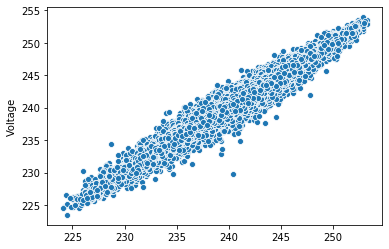

In [280]:
sns.scatterplot(pred_ts, y_test)

#### Decision Trees

In [281]:
from sklearn.tree import DecisionTreeRegressor

In [282]:
lr = DecisionTreeRegressor()
mod2 = lr.fit(X_train,y_train)
pred2_tr = mod2.predict(X_train)

pred2_ts = mod2.predict(X_test)

In [283]:
res2 = res2.append({'model':'Decision Tree + TS',
                  'Train R^2':r2_score(y_train,pred2_tr),'Train MAE':mean_absolute_error(y_train,pred2_tr),
                  'Test R^2':r2_score(y_test,pred2_ts),'Test MAE':mean_absolute_error(y_test,pred2_ts)
                 },ignore_index=True)
                 
res2

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression + TS,0.971494,3.995902e-01,0.971424,0.399379
1,Decision Tree + TS,1.000000,2.752263e-08,0.939100,0.597178


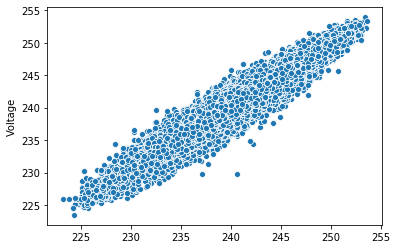

In [284]:
sns.scatterplot(pred2_ts, y_test)

#### Random Forest

In [287]:
from sklearn.ensemble import RandomForestRegressor

In [288]:
lr = RandomForestRegressor()
mod3 = lr.fit(X_train,y_train)
pred3_tr = mod3.predict(X_train)

pred3_ts = mod3.predict(X_test)

In [289]:
res2 = res2.append({'model':'Random Forest + TS',
                  'Train R^2':r2_score(y_train,pred3_tr),'Train MAE':mean_absolute_error(y_train,pred3_tr),
                  'Test R^2':r2_score(y_test,pred3_ts),'Test MAE':mean_absolute_error(y_test,pred3_ts)
                 },ignore_index=True)
res2

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression + TS,0.971494,3.995902e-01,0.971424,0.399379
1,Decision Tree + TS,1.000000,2.752263e-08,0.939100,0.597178
2,Random Forest + TS,0.995933,1.503205e-01,0.970909,0.403795


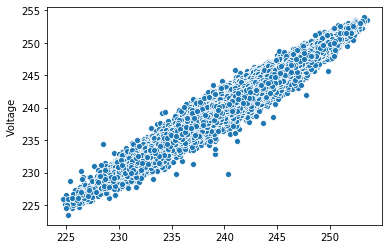

In [290]:
sns.scatterplot(pred3_ts, y_test)

#### AdaBoost

In [291]:
from sklearn.ensemble import AdaBoostRegressor

In [292]:
lr = AdaBoostRegressor()
mod4 = lr.fit(X_train,y_train)
pred4_tr = mod4.predict(X_train)

pred4_ts = mod4.predict(X_test)

In [293]:
res2 = res2.append({'model':'AdaBoost + TS',
                  'Train R^2':r2_score(y_train,pred4_tr),'Train MAE':mean_absolute_error(y_train,pred4_tr),
                  'Test R^2':r2_score(y_test,pred4_ts),'Test MAE':mean_absolute_error(y_test,pred4_ts)
                 },ignore_index=True)
res2

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression + TS,0.971494,3.995902e-01,0.971424,0.399379
1,Decision Tree + TS,1.000000,2.752263e-08,0.939100,0.597178
2,Random Forest + TS,0.995933,1.503205e-01,0.970909,0.403795
3,AdaBoost + TS,0.946707,5.796741e-01,0.946551,0.579327


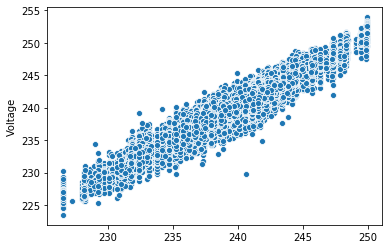

In [294]:
sns.scatterplot(pred4_ts, y_test)

#### Gradient Boosting

In [295]:
from sklearn.ensemble import GradientBoostingRegressor

In [296]:
lr = GradientBoostingRegressor()
mod5 = lr.fit(X_train,y_train)
pred5_tr = mod5.predict(X_train)

pred5_ts = mod5.predict(X_test)

In [297]:
res2 = res2.append({'model':'Gradient Boosting Machine + TS',
                  'Train R^2':r2_score(y_train,pred5_tr),'Train MAE':mean_absolute_error(y_train,pred5_tr),
                  'Test R^2':r2_score(y_test,pred5_ts),'Test MAE':mean_absolute_error(y_test,pred5_ts)
                 },ignore_index=True)
res2

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression + TS,0.971494,3.995902e-01,0.971424,0.399379
1,Decision Tree + TS,1.000000,2.752263e-08,0.939100,0.597178
2,Random Forest + TS,0.995933,1.503205e-01,0.970909,0.403795
3,AdaBoost + TS,0.946707,5.796741e-01,0.946551,0.579327
4,Gradient Boosting Machine + TS,0.971266,4.013023e-01,0.971082,0.401719


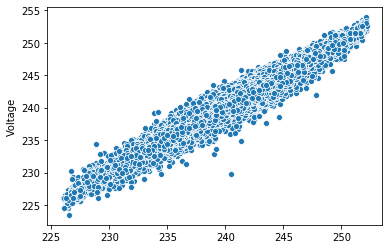

In [298]:
sns.scatterplot(pred5_ts, y_test)

In [300]:
res2

,model,Train R^2,Train MAE,Test R^2,Test MAE
0,Linear Regression + TS,0.971494,3.995902e-01,0.971424,0.399379
1,Decision Tree + TS,1.000000,2.752263e-08,0.939100,0.597178
2,Random Forest + TS,0.995933,1.503205e-01,0.970909,0.403795
3,AdaBoost + TS,0.946707,5.796741e-01,0.946551,0.579327
4,Gradient Boosting Machine + TS,0.971266,4.013023e-01,0.971082,0.401719


### Comparative results


Baseline:
<code>    
	model	                        Train R^2	Train MAE	Test R^2	Test MAE
0	Linear Regression - Baseline	 0.248241	2.123676	0.247761	2.124228
1	Decision Tree	                0.745974	0.935871	0.393154	1.814220
2	Random Forest	                0.725051	1.139726	0.518989	1.634894
3	AdaBoost	                     0.250344	2.166626	0.249208	2.166017
4	Gradient Boosting Machine	    0.380832	1.942226	0.378466	1.943867
</code>  

Enriched with TS data
<code>

model	                            Train R^2	Train MAE	Test R^2	Test MAE
0	Linear Regression + TS	        0.971494	0.3995902	0.971424	0.399379
1	Decision Tree + TS	            1.000000	2.752e-08	0.939100	0.597178
2	Random Forest + TS	            0.995933	0.1503205	0.970909	0.403795
3	AdaBoost + TS	                 0.946707    0.5796741	0.946551	0.579327
4	Gradient Boosting Machine + TS	0.971266	0.4013023	0.971082	0.401719
</code>


### Occam's (Ockham's) razor Principle or Law of Parsimony

Is a is the problem-solving principle taken from philosophy that states that: "Entities should not be multiplied unnecessarily" or in layman's terms, the simplest explanation is usually the best one. In other words, keep it as simple as possible!